In [1]:
import seaborn as sbn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from pathlib import Path
import sys
import os
# Define the project root directory
project_root = os.path.dirname(os.path.dirname(os.getcwd())) + "/harmonize_project"

# Add the project root to the system path for importing custom modules
sys.path.append(project_root)

from lib.utils import extract_experiment_data # noqa


# Age regression

## Site-target dependence

In [2]:
# Define the directory containing the prediction files
exp_dir = project_root + "/output/predictions_age_regression/site-target_dependence/"

# List of harmonization methods to process
methods = ["WDH", "Unharmonized", "PrettyHarmonize", "TTL", "NoTarget"]

# Initialize an empty DataFrame to store the combined results
results = pd.DataFrame()

# Loop through each harmonization method
for method in methods:
    # Initialize a temporary DataFrame to store results for the current method
    results_method = pd.DataFrame()

    print(f"Processing method: {method}")

    # Load the predicted values (y_pred) for the current method
    results_method["y_pred"] = pd.read_csv(
        exp_dir + f"y_pred_{method}.csv", index_col=0
    ).dropna(axis=1).to_numpy().ravel()

    # Load the true values (y_true)
    results_method["y_true"] = pd.read_csv(
        exp_dir + "y_true.csv", index_col=0
    ).dropna(axis=1).to_numpy().ravel()

    # Load the site information
    results_method["site"] = pd.read_csv(
        exp_dir + "sites.csv", index_col=0
    ).dropna(axis=1).to_numpy().ravel()

    # Calculate the difference between true and predicted values
    results_method["y_diff"] = results_method["y_true"] - results_method["y_pred"]

    # Add a column to indicate the harmonization scheme
    results_method["Harmonization Scheme"] = method

    # Append the results for the current method to the main results DataFrame
    results = pd.concat([results, results_method], ignore_index=True)

# The `results` DataFrame now contains combined data for all methods

Processing method: WDH
Processing method: Unharmonized
Processing method: PrettyHarmonize
Processing method: TTL
Processing method: NoTarget


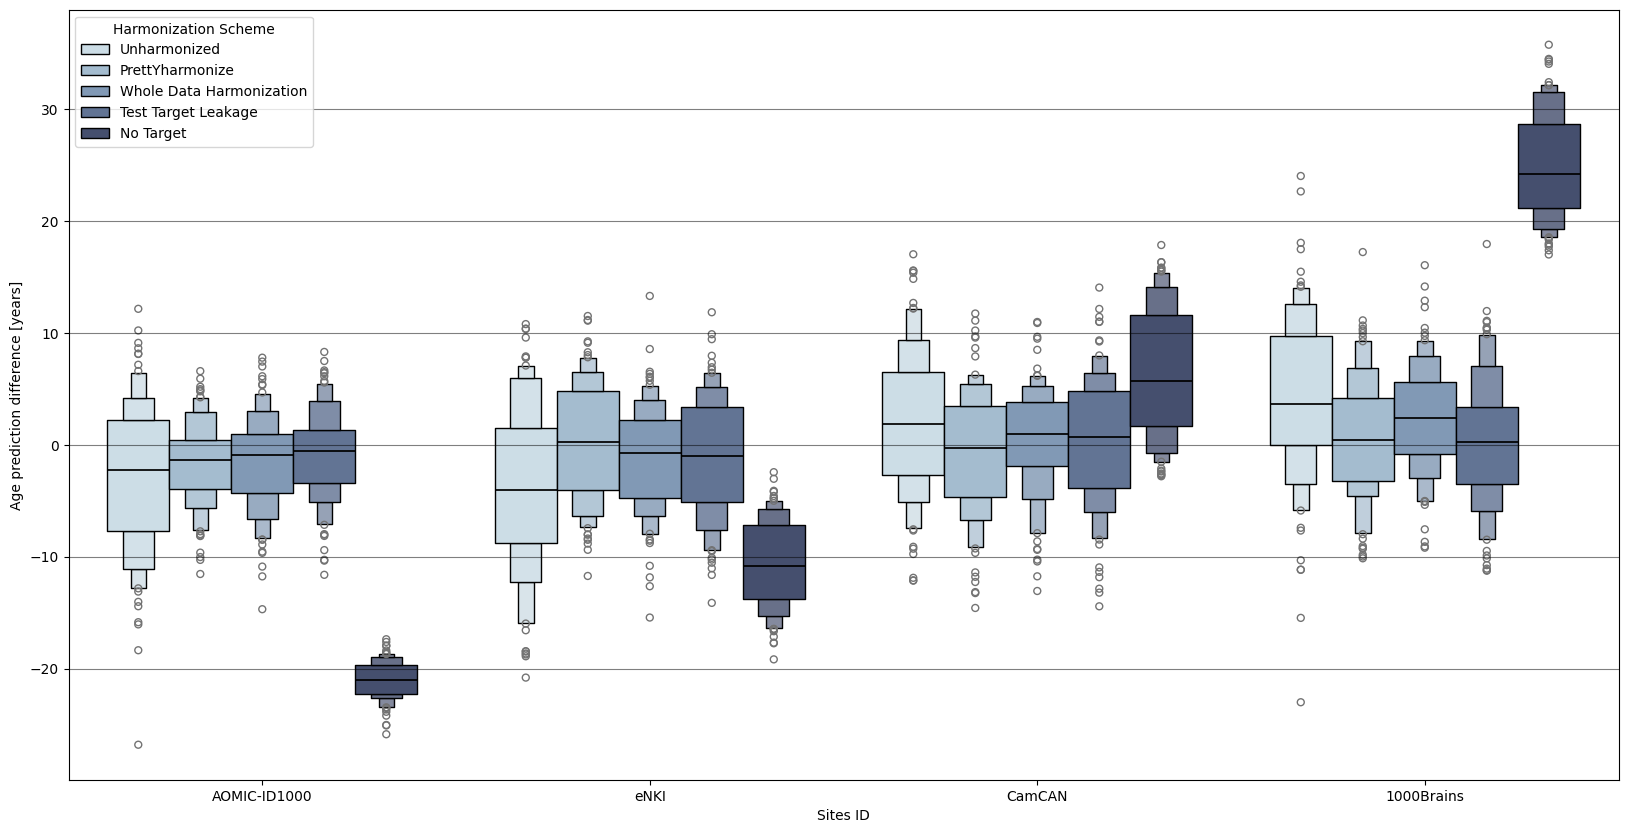

In [3]:
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3, gamma=1)
harm_modes = ["Unharmonized", "PrettYharmonize", "Whole Data Harmonization", "Test Target Leakage",  "No Target"]


results["Harmonization Scheme"].replace({"PrettyHarmonize": "PrettYharmonize",
                                "TTL": "Test Target Leakage",
                                "Unharmonized": "Unharmonized",
                                "WDH": "Whole Data Harmonization",
                                "NoTarget": "No Target"}, inplace=True)

results["site"].replace({0: "AOMIC-ID1000",
                         1: "eNKI",
                         2: "CamCAN",
                         3: "1000Brains"}, inplace=True)

sbn.boxenplot(
    data=results,
    x="site", y="y_diff", hue="Harmonization Scheme",
    outlier_prop = 1,
    palette=pal,
    linecolor="black",
    hue_order=harm_modes,
    linewidth=1
)
plt.ylabel("Age prediction difference [years]")
plt.xlabel("Sites ID")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

# Site-target independant

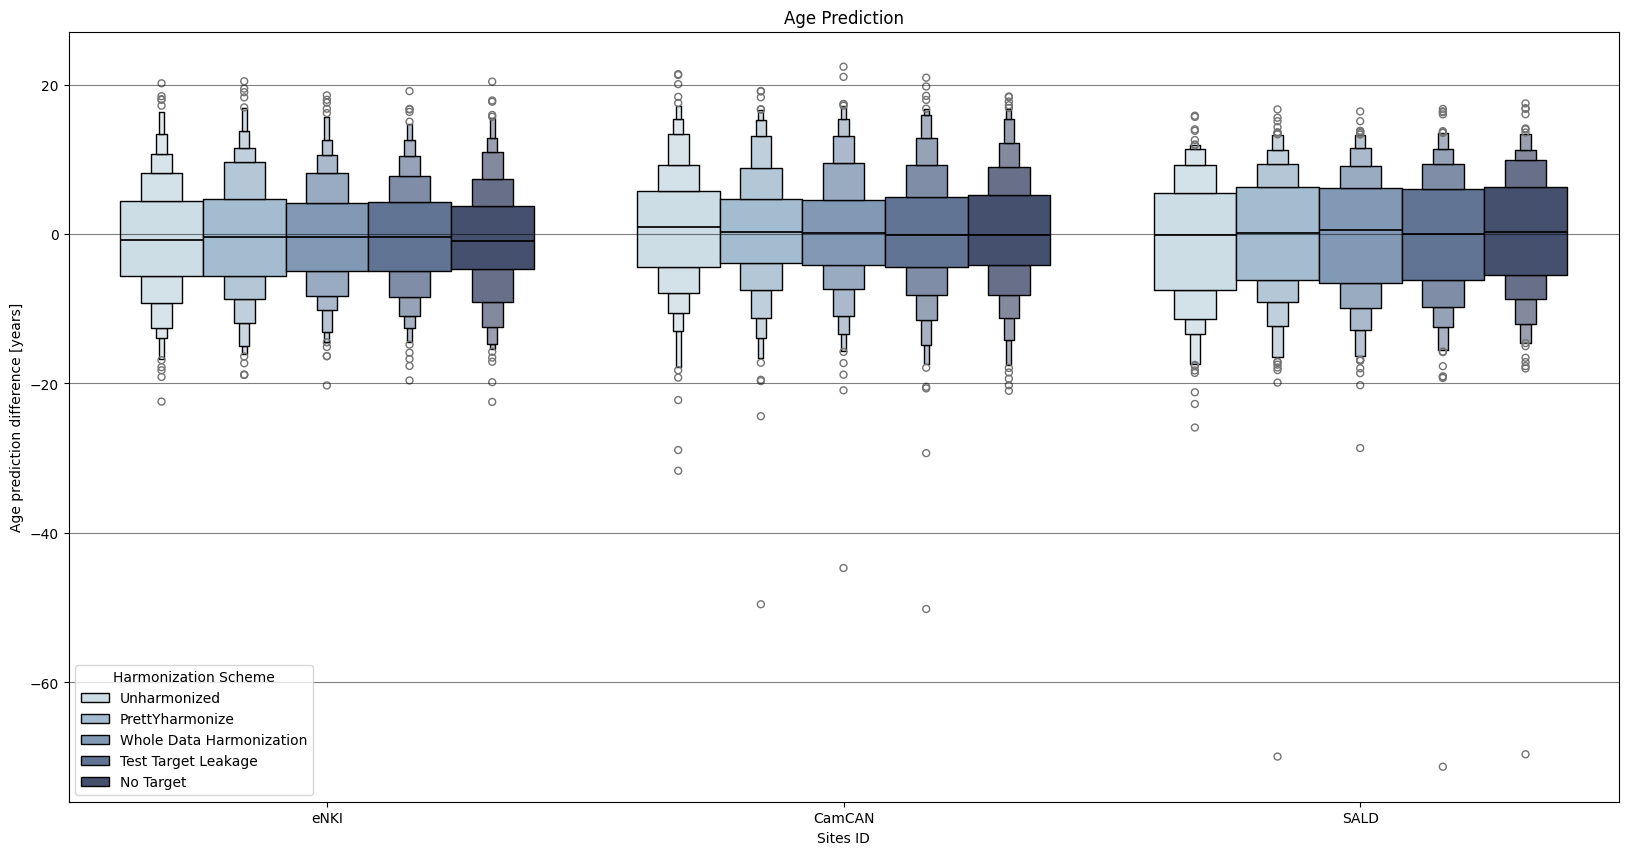

In [4]:
# Define the directory containing the prediction files
exp_dir = project_root + "/output/predictions_age_regression/"

# Define the experiments to check
experiments_to_check = {'site-target_independence'}

# Extract experiment data using the provided utility function
# This function loads and processes the data for the specified experiments
data = extract_experiment_data(exp_dir, experiments_to_check)

# Rename the column for harmonization modes to a more descriptive name
data.rename(columns={"harmonize_mode": "Harmonization Schemes"}, inplace=True)

# Replace shorthand harmonization scheme names with more descriptive ones
data["Harmonization Schemes"].replace({
    "pretend": "PrettYharmonize",
    "target": "Test Target Leakage",
    "none": "Unharmonized",
    "cheat": "Whole Data Harmonization",
    "notarget": "No Target"
}, inplace=True)

# Define the harmonization modes to include in the analysis
harm_modes = ["Unharmonized", "PrettYharmonize", "Whole Data Harmonization", "Test Target Leakage", "No Target"]

# Filter the data to include only the specified harmonization modes
data = data[data["Harmonization Schemes"].isin(harm_modes)]

# Rename the column to match the naming convention used in other parts of the notebook
data.rename(columns={"Harmonization Schemes": "Harmonization Scheme"}, inplace=True)

# Calculate the prediction difference between true and predicted values
data["y_diff"] = data["y_true"] - data["y_pred"]

# Create a figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])

# Generate a color palette for the plot
pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3)

# Create a boxen plot to visualize the prediction differences across sites and harmonization schemes
sbn.boxenplot(
    data=data,
    x="site",  # Group data by site
    y="y_diff",  # Plot the prediction difference
    hue="Harmonization Scheme",  # Use different colors for harmonization schemes
    outlier_prop=1,  # Show all data points, including outliers
    palette=pal,  # Use the generated color palette
    linecolor="black",  # Set the line color for the plot
    hue_order=harm_modes,  # Ensure consistent order of harmonization schemes
    linewidth=1  # Set the line width for the plot
)

# Add labels and title to the plot
plt.ylabel("Age prediction difference [years]")
plt.xlabel("Sites ID")
plt.title("Age Prediction")

# Add a grid to the plot for better readability
plt.grid(alpha=0.5, axis="y", c="black")

# Display the plot
plt.show()
